In [27]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import linear_model

In [28]:
def load_image(image_path):
    im_rgb = cv2.cvtColor(cv2.imread(image_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    im_gray = cv2.cvtColor(im_rgb, cv2.COLOR_RGB2GRAY)
    return im_rgb, im_gray

def detect_and_draw_lines(sobel_image, original_image, orientation="vertical"):
    # Apply binary threshold to prepare the Sobel image for Hough Transform
    _, binary = cv2.threshold(sobel_image, 50, 255, cv2.THRESH_BINARY)

    # Perform Probabilistic Hough Line Transform
    lines = cv2.HoughLinesP(
        binary,                    # Binary image (edge map)
        rho=1,                     # Distance resolution in pixels
        theta=np.pi/180,           # Angle resolution in radians
        threshold=25,             # Minimum number of intersecting points to detect a line
        minLineLength=10,          # Minimum length of line to be detected
        maxLineGap=10              # Maximum allowed gap between line segments
    )

    # Draw the detected lines on a copy of the original image
    result_image = original_image.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if orientation == "vertical":
                # Draw only vertical lines (i.e., where x-coordinates are approximately the same)
                if abs(x1 - x2) < 10:  # Allowable tolerance for a "vertical" line
                    cv2.line(result_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            elif orientation == "horizontal":
                # Draw only horizontal lines (i.e., where y-coordinates are approximately the same)
                if abs(y1 - y2) < 10:  # Allowable tolerance for a "horizontal" line
                    cv2.line(result_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    return result_image, lines

# --- Load your image ---
im_rgb, im_gray = load_image('/Users/emin/Desktop/ee475/piano-transcription/dataset/MIDItest/miditest_videos/no_hand_frames/24/frame_003293.jpg')
processing_log = [('Original Image', im_rgb)]

# --- Vertical Edge Detection (Sobel dx=1, dy=0) ---
sobel_x = cv2.Sobel(im_gray, cv2.CV_64F, dx=1, dy=0, ksize=3)
sobel_x = cv2.convertScaleAbs(sobel_x)
# sobel_x = cv2.Sobel(im_gray, cv2.CV_64F, dx=1, dy=0, ksize=1)
processing_log.append(('Vertical Edge Enhancement (Sobel)', sobel_x))

# --- Horizontal Edge Detection (Sobel dx=0, dy=1) ---
sobel_y = cv2.Sobel(im_gray, cv2.CV_64F, dx=0, dy=1, ksize=3)
sobel_y = cv2.convertScaleAbs(sobel_y)
processing_log.append(('Horizontal Edge Enhancement (Sobel)', sobel_y))

# --- Detect Vertical Lines ---
hough_vertical, vertical_lines = detect_and_draw_lines(sobel_x, im_rgb, orientation="vertical")
processing_log.append(('Hough Transform with Vertical Lines', hough_vertical))

# --- Detect Horizontal Lines ---
hough_horizontal, horizontal_lines = detect_and_draw_lines(sobel_y, im_rgb, orientation="horizontal")
processing_log.append(('Hough Transform with Horizontal Lines', hough_horizontal))

# --- Combine Vertical and Horizontal Lines into a Single Image ---
combined_lines = hough_vertical.copy()
if horizontal_lines is not None:
    for line in horizontal_lines:
        x1, y1, x2, y2 = line[0]
        # Overlay horizontal lines in blue on the combined image
        if abs(y1 - y2) < 10:  # Horizontal lines only
            cv2.line(combined_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)

processing_log.append(('Combined Hough Transform with Vertical and Horizontal Lines', combined_lines))


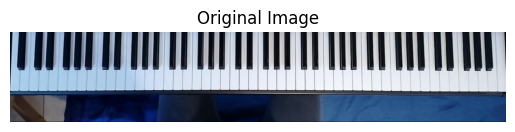

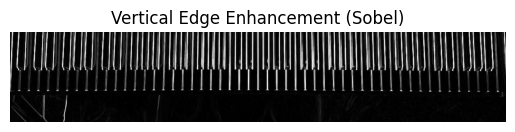

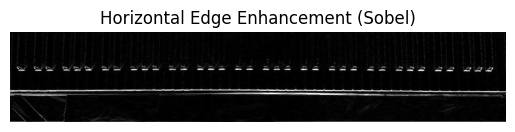

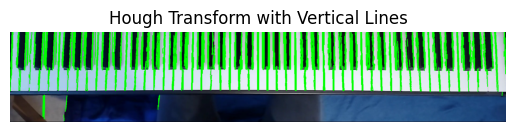

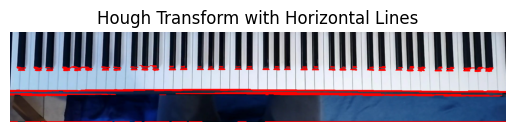

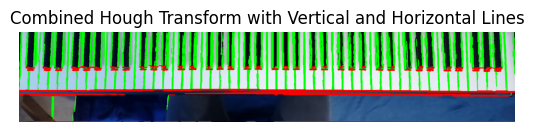

In [29]:
for title, img in processing_log:
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()  